In [ ]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5


fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5


In [ ]:
!pip install -r requirements.txt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_yaml_content = """
train: /content/drive/MyDrive/datasetCapstone/dataset/object detection/train
val: /content/drive/MyDrive/datasetCapstone/dataset/object detection/valid

nc: 1
names: ['fish_eye']
"""

with open('data.yaml', 'w') as file:
    file.write(data_yaml_content)


In [ ]:
!python train.py --img 640 --batch 16 --epochs 100 --data ./data.yaml --weights yolov5s.pt

2024-06-20 14:33:40.348976: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 14:33:40.349036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 14:33:40.350965: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=./data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, op

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-6-20 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
WARNING ⚠️ NMS time limit 0.550s exceeded


1/1 [==============================] - 0s 40ms/step


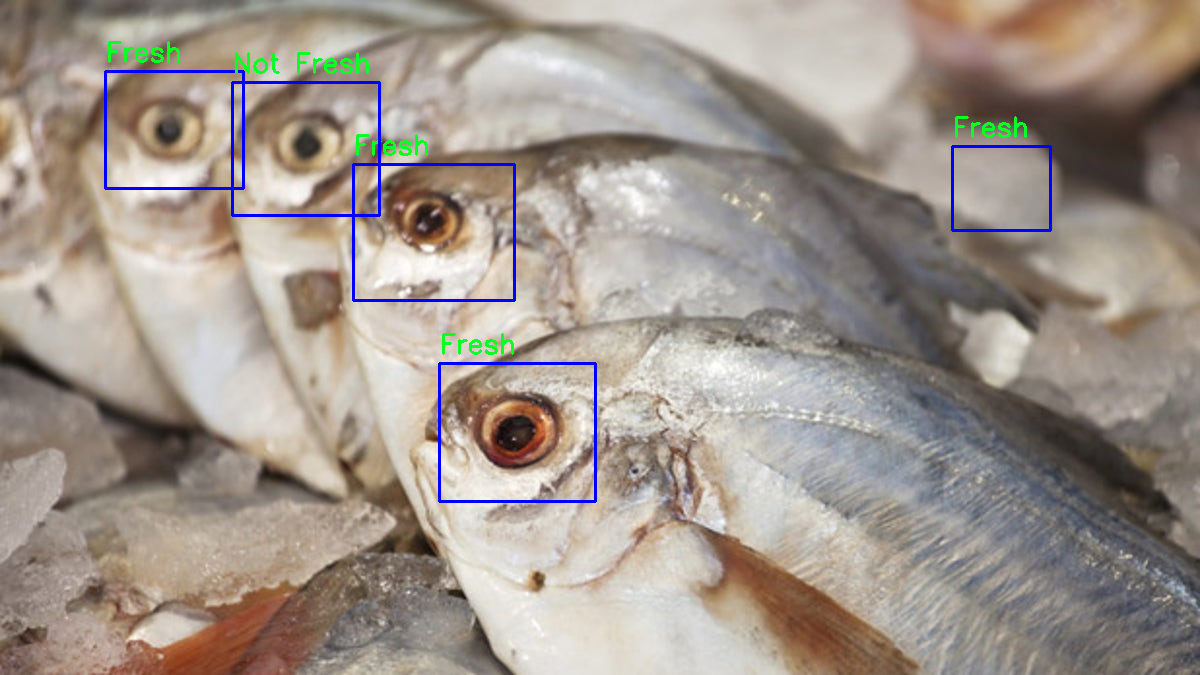

'Fresh'

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import torch
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow

class FishFreshnessModel:
    def __init__(self, detection_model_path, classification_model_path):
        # Load the YOLOv5 model for eye detection
        self.detection_model = torch.hub.load('ultralytics/yolov5', 'custom', path=detection_model_path)
        # Load the pre-trained classification model
        self.classification_model = load_model(classification_model_path)

    def preprocess_image(self, image):
        # Preprocess the image to fit the classification model input
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        img = img / 255.0
        img = np.expand_dims(img, axis=0)
        return img

    def detect_eye_and_classify_freshness(self, image_path):
        # Read the image
        img = cv2.imread(image_path)
        if img is None:
            raise FileNotFoundError(f"Image at path '{image_path}' not found or cannot be read.")

        # Perform object detection to find the fish eye
        results = self.detection_model(img)

        # Check if any detections were made
        if len(results.xyxy[0]) == 0:
            raise ValueError("No fish eye detected in the image.")

        # Loop over the detections
        for det in results.xyxy[0]:
            xmin, ymin, xmax, ymax, conf, cls = det

            # Crop the detected eye region
            cropped_eye = img[int(ymin):int(ymax), int(xmin):int(xmax)]

            # Preprocess the cropped eye image
            processed_eye = self.preprocess_image(cropped_eye)

            # Classify the freshness of the fish
            prediction = self.classification_model.predict(processed_eye)
            predicted_class = np.argmax(prediction, axis=1)

            # Map prediction to class label
            class_labels = ['Fresh', 'Not Fresh']
            freshness = class_labels[predicted_class[0]]

            # Draw the bounding box and label on the original image
            cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 2)
            cv2.putText(img, freshness, (int(xmin), int(ymin)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

        # Display the image with the result using cv2_imshow for Colab
        cv2_imshow(img)

        return freshness

# Set the correct paths for the models
detection_model_path = '/content/drive/MyDrive/datasetCapstone/best.pt'
classification_model_path = '/content/drive/MyDrive/datasetCapstone/fish_freshness_model_1.h5'

# Instantiate the combined model
combined_model = FishFreshnessModel(detection_model_path, classification_model_path)

# Test the combined model
test_image_path = '/content/test image 101.jpg'
combined_model.detect_eye_and_classify_freshness(test_image_path)


In [ ]:
import pickle

# Save the combined model
with open('/content/drive/MyDrive/datasetCapstone/combined_fish_freshness_model.pkl', 'wb') as file:
    pickle.dump(combined_model, file)


1/1 [==============================] - 0s 60ms/step


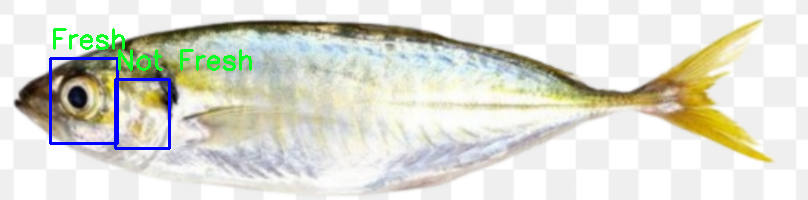

'Not Fresh'

In [ ]:
import pickle

# Load the combined model
with open('/content/drive/MyDrive/datasetCapstone/combined_fish_freshness_model.pkl', 'rb') as file:
    loaded_combined_model = pickle.load(file)

# Test the loaded combined model
test_image_path = '/content/Capture76567576.PNG'
loaded_combined_model.detect_eye_and_classify_freshness(test_image_path)
